In [8]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
"""
file: mnist_acgan.py
author: Luke de Oliveira (lukedeo@vaitech.io)

Train an Auxiliary Classifier Generative Adversarial Network (ACGAN) on the
MNIST dataset. See https://arxiv.org/abs/1610.09585 for more details.

You should start to see reasonable images after ~5 epochs, and good images
by ~15 epochs. You should use a GPU, as the convolution-heavy operations are
very slow on the CPU. Prefer the TensorFlow backend if you plan on iterating, as
the compilation time can be a blocker using Theano.

Timings:

Hardware           | Backend | Time / Epoch
-------------------------------------------
 CPU               | TF      | 3 hrs
 Titan X (maxwell) | TF      | 4 min
 Titan X (maxwell) | TH      | 7 min

Consult https://github.com/lukedeo/keras-acgan for more information and
example output
"""
from __future__ import print_function

from collections import defaultdict
import cPickle as pickle
#import cPickle as Pickle

from PIL import Image
#from Pillow import Image

from six.moves import range

import keras.backend as K
from keras.datasets import cifar10#mnist
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, merge, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Convolution2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np

np.random.seed(1337)

K.set_image_dim_ordering('th')

imaChan = 3 # image channels
imageDim = 64 # image size 
numClass = 6 # number of classes, range = 0,...,numClass-1

Using TensorFlow backend.


### Data

In [2]:
!ls ../data

faces_wiki_crop_clean_128_images.pkl
faces_wiki_crop_clean_128_labels.pkl
faces_wiki_crop_clean_64_aligned_images.pkl
faces_wiki_crop_clean_64_aligned_labels.pkl
faces_wiki_crop_clean_64_images.pkl
faces_wiki_crop_clean_64_labels.pkl


In [3]:
def getData():
    # Faces
    with open('../data/faces_wiki_crop_clean_64_aligned_images.pkl', 'rb') as handle:
        imaArr = pickle.load(handle)
    with open('../data/faces_wiki_crop_clean_64_aligned_labels.pkl', 'rb') as handle:
        imaLabels = pickle.load(handle)    
    print([imaArr.shape,imaLabels.shape])
    
    # force it to be of shape (..., 1, 28, 28) with range [-1, 1]
    imaArr = imaArr.transpose((0,3,1,2))
    print([imaArr.shape,imaLabels.shape])
    imaArr = (imaArr.astype(np.float32) - 127.5) / 127.5
    
    # split data
    ntrain=22000

    X_train, y_train = imaArr[:ntrain], imaLabels[:ntrain]
    X_test, y_test = imaArr[ntrain:], imaLabels[ntrain:]
    imaArr, imaLabels=0,0
    # reduce dimension
    y_train, y_test = y_train.squeeze(), y_test.squeeze()
    #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    #X_train = np.expand_dims(X_train, axis=1)

    # reduce training set for testing
    ntrain=1000
    X_train, y_train = X_train[:ntrain], y_train[:ntrain]

    #X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    #X_test = np.expand_dims(X_test, axis=1)

    # reduce test set for testing
    ntest=100
    X_test, y_test = X_test[:ntest], y_train[:ntest]

    print([X_train.shape,y_train.shape])
    print([X_test.shape,y_test.shape])
    return X_train,y_train,X_test,y_test

In [4]:
X_train, y_train, X_test, y_test = getData()
nb_train, nb_test = X_train.shape[0], X_test.shape[0]

[(23373, 64, 64, 3), (23373,)]
[(23373, 3, 64, 64), (23373,)]
[(1000, 3, 64, 64), (1000,)]
[(100, 3, 64, 64), (100,)]


In [5]:
def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 1, 28, 28)
    
    idim = imageDim
    
    cnn = Sequential()

    cnn.add(Dense(1024, input_dim=latent_size, activation='relu'))
    cnn.add(Dense(128 * idim/4 * idim/4, activation='relu'))
    cnn.add(Reshape((128, idim/4, idim/4)))

    # upsample to (..., idim/2, idim/2)
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Convolution2D(256, 5, 5, border_mode='same',
                          activation='relu', init='glorot_normal'))

    # upsample to (..., idim, idim)
    cnn.add(UpSampling2D(size=(2, 2)))
    cnn.add(Convolution2D(128, 5, 5, border_mode='same',
                          activation='relu', init='glorot_normal'))

    # take a channel axis reduction
    cnn.add(Convolution2D(imaChan, 2, 2, border_mode='same',
                          activation='tanh', init='glorot_normal'))

    # this is the z space commonly refered to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    # number classes in age groups #MNIST
    cls = Flatten()(Embedding(numClass, latent_size,
                              init='glorot_normal')(image_class))

    # hadamard product between z-space and a class conditional embedding
    h = merge([latent, cls], mode='mul')

    fake_image = cnn(h)

    return Model(input=[latent, image_class], output=fake_image)

def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Convolution2D(32, 3, 3, border_mode='same', subsample=(2, 2),
                          input_shape=(imaChan, imageDim, imageDim)))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Convolution2D(128, 3, 3, border_mode='same', subsample=(2, 2)))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Convolution2D(256, 3, 3, border_mode='same', subsample=(1, 1)))
    cnn.add(LeakyReLU())
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(imaChan, imageDim, imageDim))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(10, activation='softmax', name='auxiliary')(features)

    return Model(input=image, output=[fake, aux])

### main

In [6]:
# batch and latent size taken from the paper
nb_epochs = 1#50
batch_size = 32#100
latent_size = 100

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.0002
adam_beta_1 = 0.5

# build the discriminator
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

# build the generator
generator = build_generator(latent_size)
generator.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
                  loss='binary_crossentropy')

latent = Input(shape=(latent_size, ))
image_class = Input(shape=(1,), dtype='int32')

# get a fake image
fake = generator([latent, image_class])

# we only want to be able to train generation for the combined model
discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model(input=[latent, image_class], output=[fake, aux])

combined.compile(
    optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)

In [9]:
train_history = defaultdict(list)
test_history = defaultdict(list)

ct = time.time()
for epoch in range(nb_epochs):
    print('Epoch {} of {}'.format(epoch + 1, nb_epochs))

    nb_batches = int(X_train.shape[0] / batch_size)
    progress_bar = Progbar(target=nb_batches)

    epoch_gen_loss = []
    epoch_disc_loss = []

    for index in range(nb_batches):
        progress_bar.update(index)
        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (batch_size, latent_size))

        # get a batch of real images
        image_batch = X_train[index * batch_size:(index + 1) * batch_size]
        label_batch = y_train[index * batch_size:(index + 1) * batch_size]

        # sample some labels from p_c
        sampled_labels = np.random.randint(0, numClass, batch_size)

        # generate a batch of fake images, using the generated labels as a
        # conditioner. We reshape the sampled labels to be
        # (batch_size, 1) so that we can feed them into the embedding
        # layer as a length one sequence
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

        X = np.concatenate((image_batch, generated_images))
        y = np.array([1] * batch_size + [0] * batch_size)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        epoch_disc_loss.append(discriminator.train_on_batch(X, [y, aux_y]))

        # make new noise. we generate 2 * batch size here such that we have
        # the generator optimize over an identical number of images as the
        # discriminator
        noise = np.random.uniform(-1, 1, (2 * batch_size, latent_size))
        sampled_labels = np.random.randint(0, numClass, 2 * batch_size)

        # we want to train the genrator to trick the discriminator
        # For the generator, we want all the {fake, not-fake} labels to say
        # not-fake
        trick = np.ones(2 * batch_size)

        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

    print('\nTesting for epoch {}:'.format(epoch + 1))

    # evaluate the testing loss here

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (nb_test, latent_size))

    # sample some labels from p_c and generate images from them
    sampled_labels = np.random.randint(0, numClass, nb_test)
    generated_images = generator.predict(
        [noise, sampled_labels.reshape((-1, 1))], verbose=False)

    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * nb_test + [0] * nb_test)
    aux_y = np.concatenate((y_test, sampled_labels), axis=0)

    # see if the discriminator can figure itself out...
    discriminator_test_loss = discriminator.evaluate(
        X, [y, aux_y], verbose=False)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    # make new noise
    noise = np.random.uniform(-1, 1, (2 * nb_test, latent_size))
    sampled_labels = np.random.randint(0, numClass, 2 * nb_test)

    trick = np.ones(2 * nb_test)

    generator_test_loss = combined.evaluate(
        [noise, sampled_labels.reshape((-1, 1))],
        [trick, sampled_labels], verbose=False)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    # generate an epoch report on performance
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *discriminator.metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))

    # save weights every epoch
    generator.save_weights(
        'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
    discriminator.save_weights(
        'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

    # generate some digits to display
    noise = np.random.uniform(-1, 1, (10*numClass, latent_size))

    sampled_labels = np.array([
        [i] * 10 for i in range(numClass)
    ]).reshape(-1, 1)

    # get a batch to display
    generated_images = generator.predict(
        [noise, sampled_labels], verbose=0)

    # arrange them into a grid
    if imaChan==1:
        img = (np.concatenate([r.reshape(-1, imageDim)
                               for r in np.split(generated_images, 10)
                               ], axis=-1) * 127.5 + 127.5).astype(np.uint8)
    else:
        img = (np.concatenate([r.transpose(0,2,3,1).reshape(-1, imageDim,3)
                           for r in np.split(generated_images, 10)
                           ], axis=1) * 127.5 + 127.5).astype(np.uint8)
        

    Image.fromarray(img).save(
        'plot_epoch_{0:03d}_generated.png'.format(epoch))

    pickle.dump({'train': train_history, 'test': test_history},
    open('acgan-history.pkl', 'wb'))

print("Elapsed time= {} min".format((time.time()-ct)/60.))

Epoch 1 of 1
30/31 [============================>.] - ETA: 0s  

In [223]:
generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=0)

In [10]:
generated_images.shape

(60, 3, 64, 64)

In [11]:
img = (np.concatenate([r.transpose(0,2,3,1).reshape(-1, imageDim,3)
                           for r in np.split(generated_images, 10)
                           ], axis=1) * 127.5 + 127.5).astype(np.uint8)
img.shape

(384, 640, 3)

In [17]:
tmp = np.split(generated_images,6,axis=0)
len(tmp)
print(tmp[0].shape)

(10, 3, 64, 64)


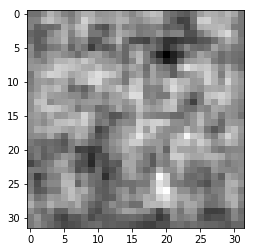

In [224]:
plt.imshow(generated_images[1,0,:],cmap='gray')

In [13]:
sampled_labels = np.random.randint(0, numClass, 2 * nb_test)

### Data

In [1]:
plt.imshow(img)

NameError: name 'plt' is not defined

In [87]:
generator.layers[5].input_shape

(None, 100)